# Error Analysis

Find localisation error using control lines

The strategy is the following:

- Register points across channels before and after chromatic aberration correction
- Do the step above using multiple distance cutoff on registration
- Error will be given by the standard deviation of the distances after correction

In [1]:
import glob
import sys
import os

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import scipy
import scipy.optimize
sys.path.append("../source/dual_channel_analysis/")
from utils import chromatic_aberration_correction
from IPython.display import Markdown as md
matplotlib.use("Agg")

%matplotlib inline

In [2]:
def register_points_using_euclidean_distance(
    reference: pd.DataFrame, moving: pd.DataFrame, distance_cutoff: float = 0.1
):
    """Given dataframe containing reference and moving coordinates, get the two sets of matched points"""

    cdist = scipy.spatial.distance.cdist(reference, moving, metric="euclidean")
    rows, cols = scipy.optimize.linear_sum_assignment(cdist)
    for r, c in zip(rows, cols):
        if cdist[r, c] > distance_cutoff:
            rows = rows[rows != r]
            cols = cols[cols != c]

    reference = np.array([reference[i] for i in rows])
    moving = np.array([moving[i] for i in cols])

    return reference, moving


def calculate_deviation_registred_points(channel1_files, channel2_files, path_beads):
    res = pd.DataFrame()

    for dist_cutoff in [0.08, 0.09, 0.1, 0.2, 0.3, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:

        channel1_coords = []
        channel2_coords = []
        channel1_coords_after_correction = []
        channel2_coords_after_correction = []

        for idx in range(len(channel1_files)):

            channel1 = pd.read_csv(channel1_files[idx])
            channel2 = pd.read_csv(channel2_files[idx])

            (
                channel1_coords_curr,
                channel2_coords_curr,
            ) = register_points_using_euclidean_distance(
                reference=channel1[[X, Y, Z]].values,
                moving=channel2[[X, Y, Z]].values,
                distance_cutoff=dist_cutoff,
            )

            (
                channel2_coords_after_correction_curr,
                sx,
                sy,
                sz,
            ) = chromatic_aberration_correction(
                directory=path_beads,
                coords=channel2[[X, Y, Z]].values,
                channel_to_correct=2,
                distance_cutoff=0.1,
                quality=f"{outdir}/chromatic_aberration_correction_quality.pdf",
            )

            (
                channel1_coords_after_correction_curr,
                channel2_coords_after_correction_curr,
            ) = register_points_using_euclidean_distance(
                reference=channel1[[X, Y, Z]].values,
                moving=channel2_coords_after_correction_curr,
                distance_cutoff=dist_cutoff,
            )

            if len(channel1_coords_curr):
                channel1_coords.append(channel1_coords_curr)

            if len(channel2_coords_curr):
                channel2_coords.append(channel2_coords_curr)

            if len(channel1_coords_after_correction_curr):
                channel1_coords_after_correction.append(
                    channel1_coords_after_correction_curr
                )
            if len(channel2_coords_after_correction_curr):
                channel2_coords_after_correction.append(
                    channel2_coords_after_correction_curr
                )
        
        if len(channel1_coords) == 0 and len(channel1_coords_after_correction) == 0:
            continue
        channel1_coords = np.concatenate(channel1_coords)
        channel2_coords = np.concatenate(channel2_coords)
        channel1_coords_after_correction = np.concatenate(
            channel1_coords_after_correction
        )
        channel2_coords_after_correction = np.concatenate(
            channel2_coords_after_correction
        )

        axis = ["x", "y", "z"]
        for i in range(len(axis)):
            diff1 = (
                channel1_coords_after_correction[..., i]
                - channel2_coords_after_correction[..., i]
            )
            diff2 = channel1_coords[..., i] - channel2_coords[..., i]

            dictionary = {
                "mean_before": np.mean(diff2),
                "mean_after": np.mean(diff1),
                "sd_before": np.std(diff2),
                "sd_after": np.std(diff1),
                "axis": axis[i],
                "dist_cutoff": dist_cutoff,
                "number_points_after": len(channel1_coords_after_correction),
                "number_points_before": len(channel1_coords),
            }
            res = pd.concat([res, pd.DataFrame(dictionary, index=[0])])
    return res


def plotres(res):
    fig, ax = plt.subplots(3, 3, figsize=(15, 15))
    axis = ["x", "y", "z"]
    for i in range(len(axis)):
        selection = res.axis == axis[i]
        ax[0, i].plot(
            res.dist_cutoff[selection], res.number_points_before[selection], "-o"
        )
        ax[0, i].plot(
            res.dist_cutoff[selection], res.number_points_after[selection], "-o"
        )
        ax[0, i].legend(["Before correction", "After correction"])
        if i == 0:
            ax[0, i].set_ylabel("Number of registred points")
    for i in range(len(axis)):
        selection = res.axis == axis[i]
        ax[1, i].axhline(y=0, color="r", linestyle="-")
        ax[1, i].plot(res.dist_cutoff[selection], res.mean_before[selection], "-o")
        ax[1, i].plot(res.dist_cutoff[selection], res.mean_after[selection], "-o")
        ax[1, i].legend(["Before correction", "After correction"])
        if i == 0:
            ax[1, i].set_ylabel("Average distance between registred spots")
        ax[1, i].set_title(f"Along {axis[i]}")

    for i in range(len(axis)):
        selection = res.axis == axis[i]
        ax[2, i].plot(res.dist_cutoff[selection], res.sd_before[selection], "-o")
        ax[2, i].plot(res.dist_cutoff[selection], res.sd_after[selection], "-o")
        ax[2, i].legend(["Before correction", "After correction"])
        ax[2, i].set_xlabel("Distance cutoff for points registration")
        if i == 0:
            ax[2, i].set_ylabel("STD of distance between registred spots")
    plt.suptitle(f"{outdir}", fontsize=20)

    plt.savefig(f"{outdir}/{outname}.error_analysis.pdf")
    plt.show()

In [3]:
TRACKID = "track"
X = "x"
Y = "y"
Z = "z"
FRAME = "frame"
CELLID = "cell"
basedir = "/tungstenfs/scratch/ggiorget/zhan/2021/1105_pia_image_analysis/3d_prediction/two_colours_lines/control_lines/"

# Dataset 20210930

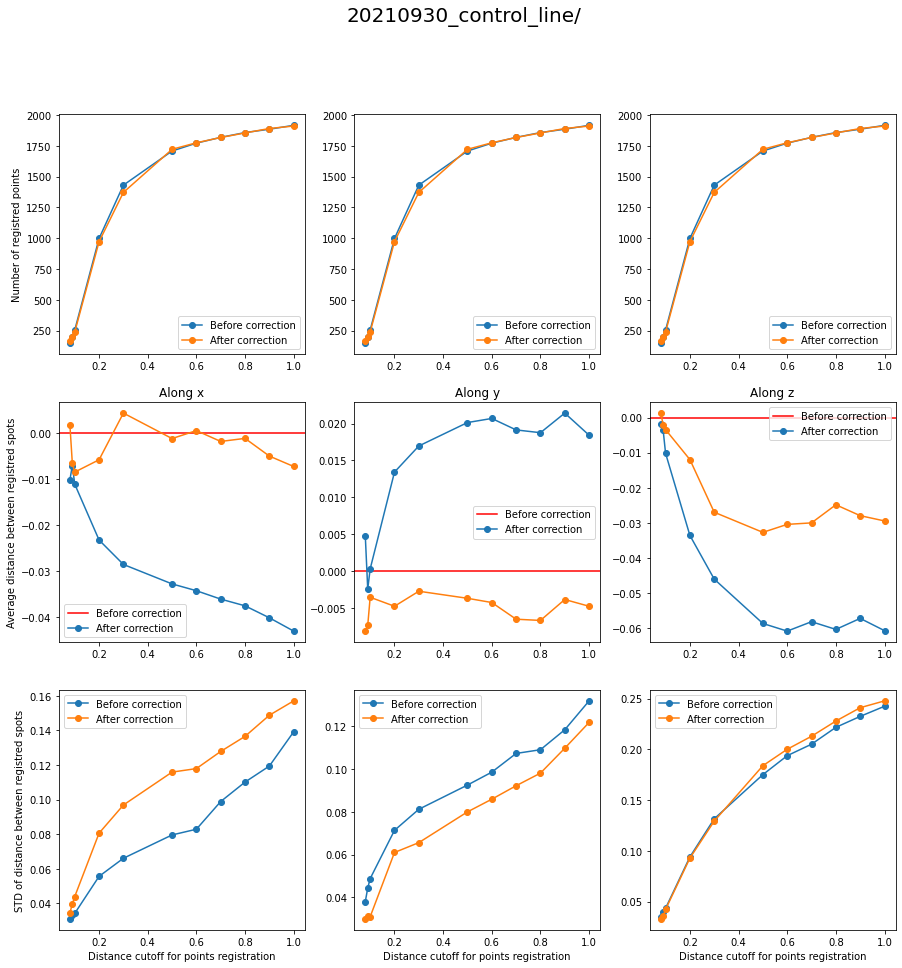

Ideal cutoff point registration cutoff seems to be 0.3um. This leads to the following errors [[0.09688432828046624 'x']
 [0.06556745052922376 'y']
 [0.12937906268926033 'z']]

In [4]:
path_beads = f"{basedir}/20210930_control_line/beads/um_based/"
path_images_to_correct = f"{basedir}/20210930_control_line/um_based/"
outdir = f"{basedir}/20210930_control_line/"
outname = "20210930_control_line"

channel1_files = sorted(glob.glob(f"{path_images_to_correct}/*w1*csv"))
names = [re.search(r"(^.*)w1", os.path.basename(x))[1] for x in channel1_files]
channel2_files = [
    glob.glob(f"{path_images_to_correct}/{name}*w2*csv")[0] for name in names
]

res0 = calculate_deviation_registred_points(channel1_files, channel2_files, path_beads)
plotres(res0)
md(
    f"Ideal cutoff point registration cutoff seems to be 0.3um. This leads to the following errors {res0[round(res0.dist_cutoff, 1)==0.3][['sd_after', 'axis']].values}"
)

### How to read the plots above


Chromatic aberration should overlay spots across channels, therefore average distance should shift to zero. If this happens, chromatic aberration is doing what it is supposed to do.

Increasing distance cutoff for point registration will assign spots across channels even if spots are further apart. Therefore increasing distance cutoff will lead to higher deviation from zero of distances across channels. A good distance cutoff seems to be 0.3um where we do not detect more deviation from zero of the distances across channels

# Dataset 20211004

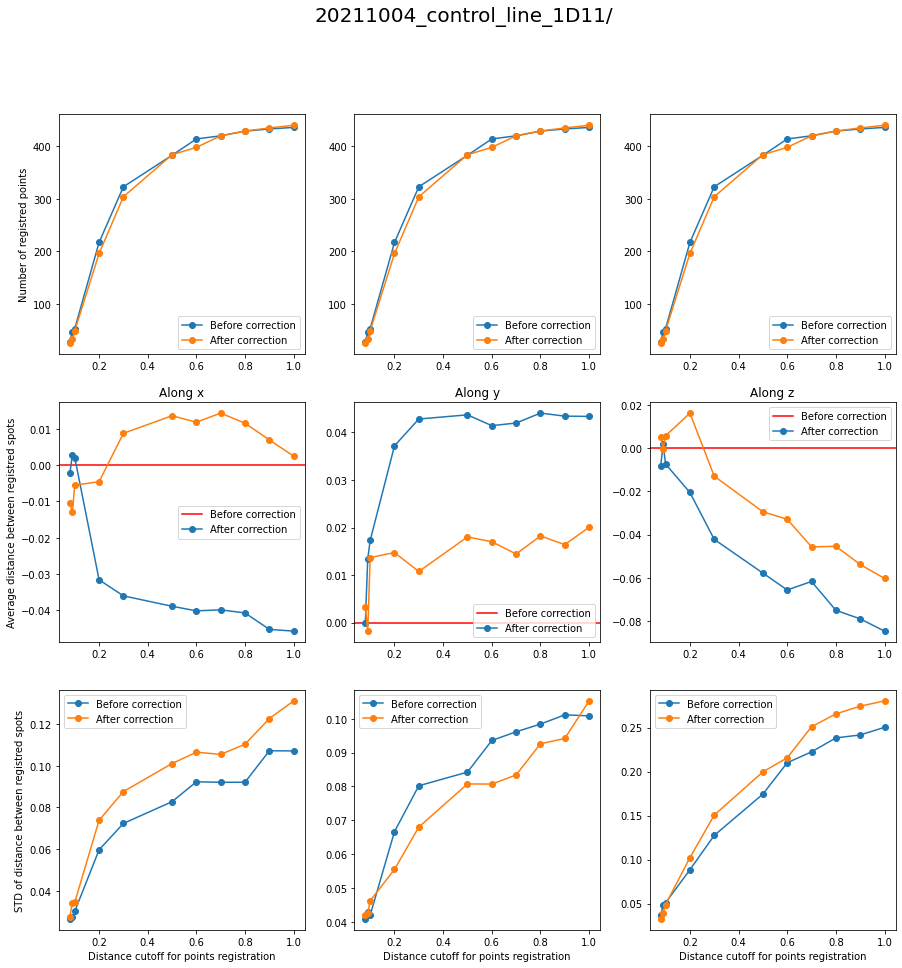

Ideal cutoff point registration cutoff seems to be 0.3um. This leads to the following errors [[0.08761435544569181 'x']
 [0.06799860970900731 'y']
 [0.15049612779682808 'z']]

In [5]:
path_beads = f"{basedir}/20211004_control_line_1D11/beads/um_based/"
path_images_to_correct = f"{basedir}/20211004_control_line_1D11/um_based/"
outdir = f"{basedir}/20211004_control_line_1D11/"
outname = "20211004_control_line_1D11"

channel1_files = sorted(glob.glob(f"{path_images_to_correct}/*w1*csv"))
names = [re.search(r"(^.*)w1", os.path.basename(x))[1] for x in channel1_files]
channel2_files = [
    glob.glob(f"{path_images_to_correct}/{name}*w2*csv")[0] for name in names
]

res1 = calculate_deviation_registred_points(channel1_files, channel2_files, path_beads)
plotres(res1)
md(
    f"Ideal cutoff point registration cutoff seems to be 0.3um. This leads to the following errors {res1[round(res1.dist_cutoff, 1)==0.3][['sd_after', 'axis']].values}"
)

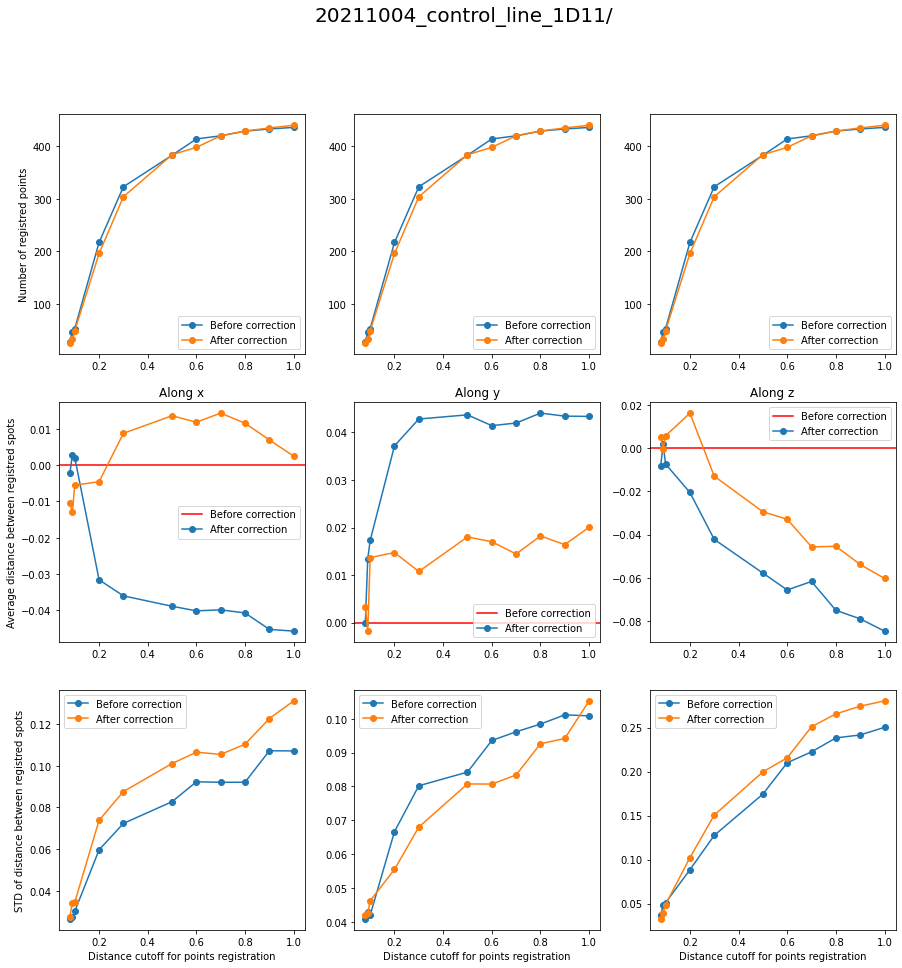

In [6]:
plotres(res1)

# Dataset 20211007

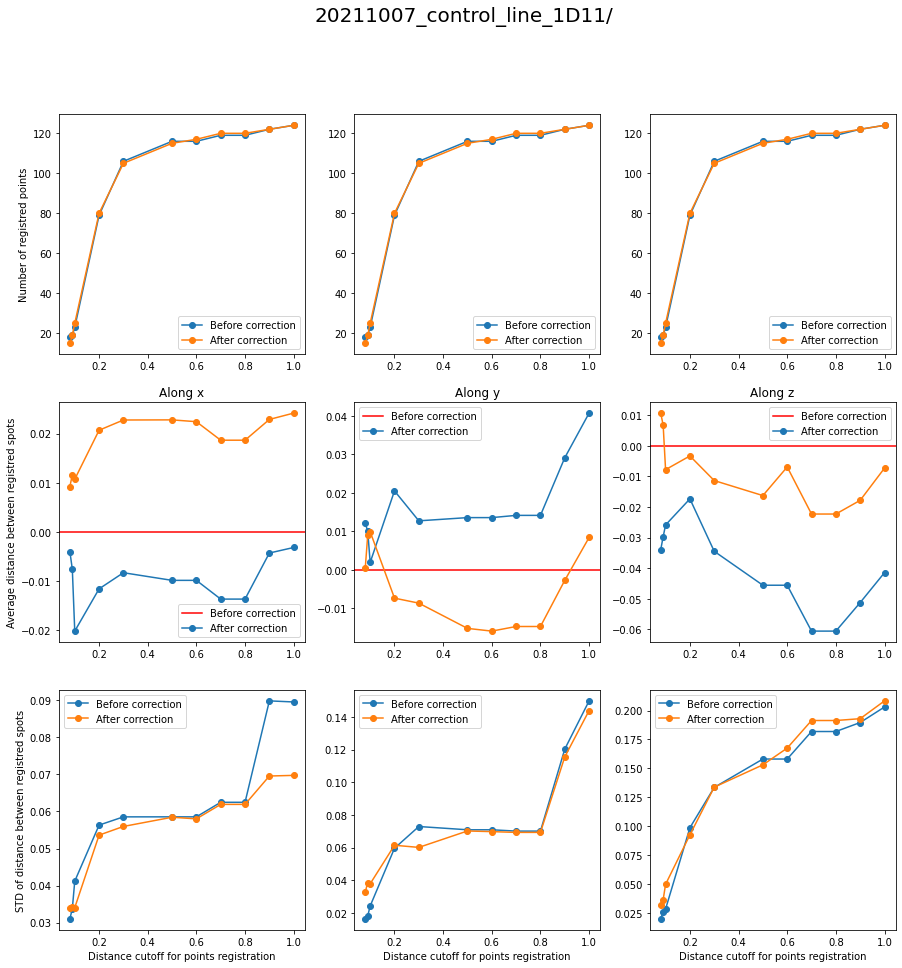

Ideal cutoff point registration cutoff seems to be 0.3um. This leads to the following errors [[0.05596396390566814 'x']
 [0.06016497230368583 'y']
 [0.13389618415014878 'z']]

In [7]:
path_beads = f"{basedir}/20211007_control_line_1D11/beads/um_based/"
path_images_to_correct = f"{basedir}/20211007_control_line_1D11/um_based/"
outdir = f"{basedir}/20211007_control_line_1D11/"
outname = "20211007_control_line_1D11"

channel1_files = sorted(glob.glob(f"{path_images_to_correct}/*w1*csv"))
names = [re.search(r"(^.*)w1", os.path.basename(x))[1] for x in channel1_files]
channel2_files = [
    glob.glob(f"{path_images_to_correct}/{name}*w2*csv")[0] for name in names
]

res2 = calculate_deviation_registred_points(channel1_files, channel2_files, path_beads)
plotres(res2)
md(
    f"Ideal cutoff point registration cutoff seems to be 0.3um. This leads to the following errors {res2[round(res2.dist_cutoff, 1)==0.3][['sd_after', 'axis']].values}"
)

# All datasets combined

Average error across all datasets

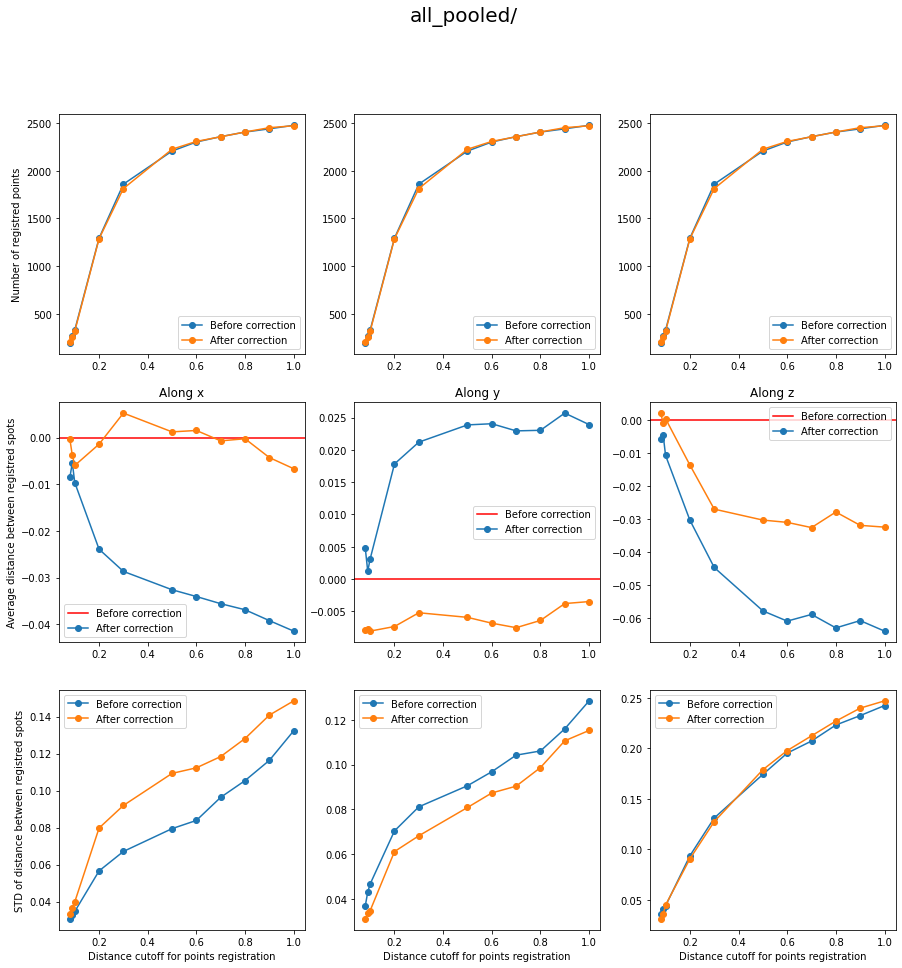

Ideal cutoff point registration cutoff seems to be 0.3um. This leads to the following errors [[0.09192618527718872 'x']
 [0.06826826254347147 'y']
 [0.12744616054273886 'z']]

In [8]:
path_beads = f"{basedir}/all_pooled/beads/um_based/"
path_images_to_correct = f"{basedir}/all_pooled/um_based/"
outdir = f"{basedir}/all_pooled/"
outname = "Control_lines_pooled"

channel1_files = sorted(glob.glob(f"{path_images_to_correct}/*w1*csv"))
names = [re.search(r"(^.*)w1", os.path.basename(x))[1] for x in channel1_files]
channel2_files = [
    glob.glob(f"{path_images_to_correct}/{name}*w2*csv")[0] for name in names
]

res = calculate_deviation_registred_points(channel1_files, channel2_files, path_beads)
plotres(res)
md(
    f"Ideal cutoff point registration cutoff seems to be 0.3um. This leads to the following errors {res[round(res.dist_cutoff, 1)==0.3][['sd_after', 'axis']].values}"
)

In [9]:
print(f"Combined error is ~ {np.sqrt(np.sum(np.square(res[round(res.dist_cutoff, 1)==0.3]['sd_after'].values)))}")

Combined error is ~ 0.17132864047615023


# Plots that will be useful for suppl fig publication

cutoff is set to 300nm

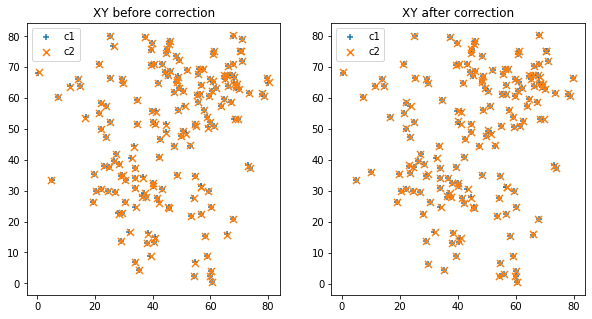

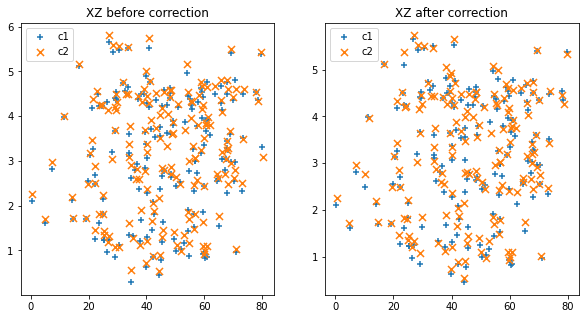

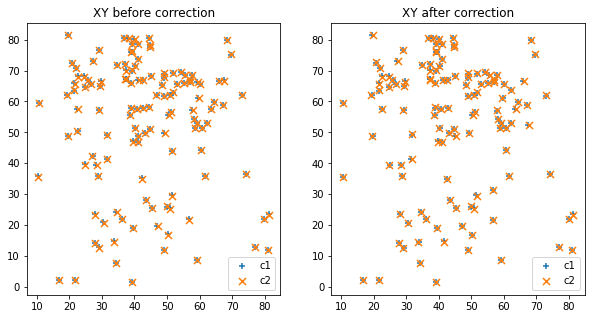

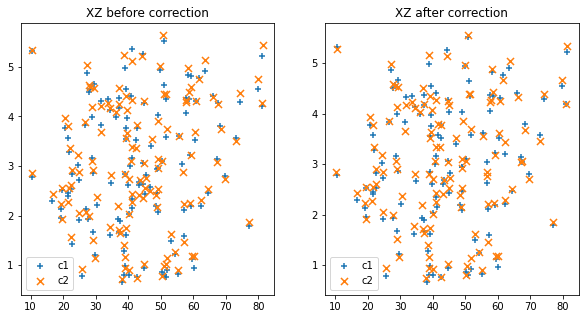

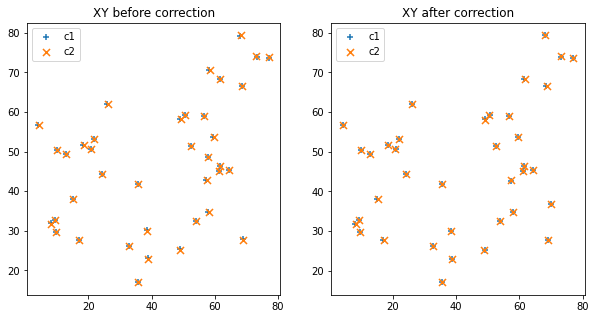

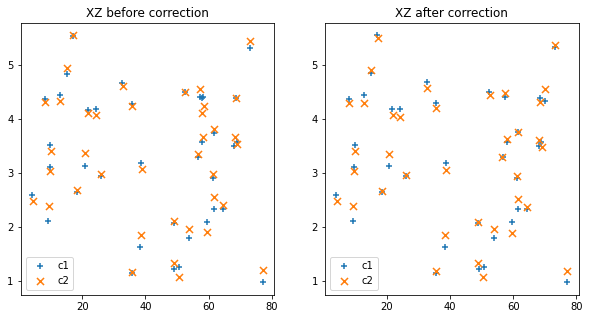

In [10]:

path_beads = f"{basedir}/all_pooled/beads/um_based/"
path_images_to_correct = f"{basedir}/all_pooled/um_based/"
outdir = f"{basedir}/all_pooled/"
outname = "Control_lines_pooled"
dist_cutoff=0.3

channel1_files = sorted(glob.glob(f"{path_images_to_correct}/*w1*csv"))
names = [re.search(r"(^.*)w1", os.path.basename(x))[1] for x in channel1_files]
channel2_files = [
    glob.glob(f"{path_images_to_correct}/{name}*w2*csv")[0] for name in names
]

channel1_coords = []
channel2_coords = []
channel1_coords_after_correction = []
channel2_coords_after_correction = []

for idx in range(len(channel1_files)):

    channel1 = pd.read_csv(channel1_files[idx])
    channel2 = pd.read_csv(channel2_files[idx])

    (
        channel1_coords_curr,
        channel2_coords_curr,
    ) = register_points_using_euclidean_distance(
        reference=channel1[[X, Y, Z]].values,
        moving=channel2[[X, Y, Z]].values,
        distance_cutoff=dist_cutoff,
    )

    (
        channel2_coords_after_correction_curr,
        sx,
        sy,
        sz,
    ) = chromatic_aberration_correction(
        directory=path_beads,
        coords=channel2[[X, Y, Z]].values,
        channel_to_correct=2,
        distance_cutoff=0.1,
        quality=f"{outdir}/chromatic_aberration_correction_quality.pdf",
    )

    (
        channel1_coords_after_correction_curr,
        channel2_coords_after_correction_curr,
    ) = register_points_using_euclidean_distance(
        reference=channel1[[X, Y, Z]].values,
        moving=channel2_coords_after_correction_curr,
        distance_cutoff=dist_cutoff,
    )

    channel1_coords.append(channel1_coords_curr)
    channel2_coords.append(channel2_coords_curr)
    channel1_coords_after_correction.append(
        channel1_coords_after_correction_curr
    )
    channel2_coords_after_correction.append(
        channel2_coords_after_correction_curr
    )
    if idx % 10 == 0:
        fig, ax = plt.subplots(1,2, figsize = (10,5))
        ax[0].scatter(channel1_coords_curr[..., 0], channel1_coords_curr[..., 1], marker="+")
        ax[0].scatter(channel2_coords_curr[..., 0], channel2_coords_curr[..., 1], marker="x", s=50)
        ax[0].set_title("XY before correction")
        ax[0].legend(["c1", "c2"])
        
        ax[1].scatter(channel1_coords_after_correction_curr[..., 0], channel1_coords_after_correction_curr[..., 1], marker="+")
        ax[1].scatter(channel2_coords_after_correction_curr[..., 0], channel2_coords_after_correction_curr[..., 1], marker="x", s=50)
        ax[1].set_title("XY after correction")
        ax[1].legend(["c1", "c2"])
        plt.show()
        
        fig, ax = plt.subplots(1,2, figsize = (10,5))
        ax[0].scatter(channel1_coords_curr[..., 0], channel1_coords_curr[..., 2], marker="+")
        ax[0].scatter(channel2_coords_curr[..., 0], channel2_coords_curr[..., 2], marker="x", s=50)
        ax[0].set_title("XZ before correction")
        ax[0].legend(["c1", "c2"])
        
        ax[1].scatter(channel1_coords_after_correction_curr[..., 0], channel1_coords_after_correction_curr[..., 2], marker="+")
        ax[1].scatter(channel2_coords_after_correction_curr[..., 0], channel2_coords_after_correction_curr[..., 2], marker="x", s=50)
        ax[1].set_title("XZ after correction")
        ax[1].legend(["c1", "c2"])
        plt.show()
    

channel1_coords = np.concatenate(channel1_coords)
channel2_coords = np.concatenate(channel2_coords)
channel1_coords_after_correction = np.concatenate(
    channel1_coords_after_correction
)
channel2_coords_after_correction = np.concatenate(
    channel2_coords_after_correction
)

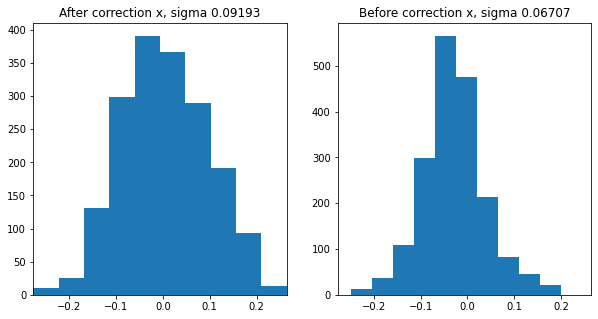

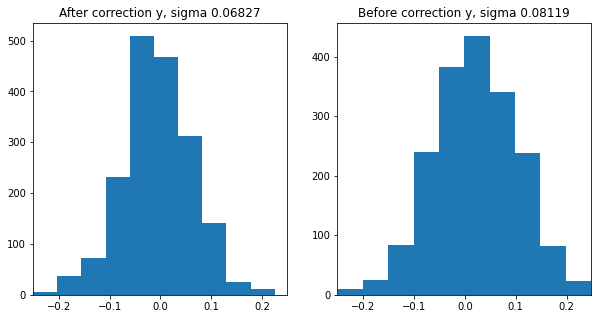

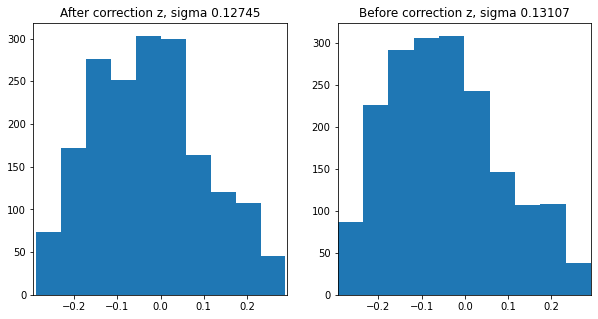

In [12]:
axis = ['x', 'y', 'z']
for i in range(len(axis)):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    diff1 = channel1_coords_after_correction[..., i] - channel2_coords_after_correction[..., i]
    diff2 = channel1_coords[..., i] - channel2_coords[..., i]

    std1 = round(np.std(diff1), 5)
    std2 = round(np.std(diff2), 5)
    minimum = np.min(np.concatenate([diff1, diff2]))
    maximum = np.max(np.concatenate([diff1, diff2]))
    ax[0].hist(diff1)
    ax[0].set_title(f"After correction {axis[i]}, sigma {std1}")
    ax[0].set_xlim(minimum, maximum)
    ax[1].hist(diff2)
    ax[1].set_title(f"Before correction {axis[i]}, sigma {std2}")
    ax[1].set_xlim(minimum, maximum)

    plt.savefig(f"distribution_along_{axis[i]}.pdf")
    plt.show()